In [1]:
#| export
print_flag                    = True
check_memory_usage            = True
time_flag                     = True
window_size_percentage        = False
show_plots                    = False
reset_kernel                  = True
pre_configured_case           = False
case_id                       = 1
frequency_factor              = 5
frequency_factor_change_alias = True
check_parameters              = True
cuda_device                   = 1 #0

# MPlot

The MPlot is used to check the distance between subsequence pairs into a time series according to a window size. This notebooks tries to: generate the Mplot for a time series


In [2]:
if check_parameters:
    print("--- Check parameters ---")
    print(
        "print_flag:", print_flag,
        "check_memory_usage", check_memory_usage,
        "time_flag:", time_flag,
        "window_size_percentage:" , window_size_percentage,
        "show_plots:",show_plots,
        "reset_kernel:",reset_kernel,
        "pre_configured_case:",pre_configured_case,
        "case_id:",case_id,
        "frequency_factor:", frequency_factor, 
        "frequency_factor_change_alias", frequency_factor_change_alias,
        "cuda_device", cuda_device
)

--- Check parameters ---
print_flag: True check_memory_usage True time_flag: True window_size_percentage: False show_plots: False reset_kernel: True pre_configured_case: False case_id: 1 frequency_factor: 5 frequency_factor_change_alias True cuda_device 1


### VsCode update patch
Initial notebook setup when using VSCode.

In [3]:
#| export
# This is only needed if the notebook is run in VSCode
import sys
import dvats.utils as ut
if '--vscode' in sys.argv:
    print("Executing inside vscode")
    ut.DisplayHandle.update = ut.update_patch

### Debugging variables

- `print_flag`. If `True` it adds debbuging messages in those functions that allows so.
- `reset_kernel`. If `True` it resets the kernel by the end of the execution. Use only in case that memory management is needed.
- `check_memory_usage`. If `True`, it adds some lines for checking the GPU memmory ussage along the execution.
- `time_flag`. If `True` it get the execution time along the notebook as well as inside those functions that allows so.
- `window_size_percentage`. If `True`, MVP will be used directly with the proposed windows sizes. Otherwise, it will be asumed that they have been taken as absolute values and execution will be take that into account.
- `show_plots`. If `True` all plots are shown within the execution of the notebook. Otherwise, none of them will be plotted.

In [4]:
#| export
##### ----- This cell should be substituted by input parameters ------ #####
##### See _ploomber_engine_example_.ipynb
##### Uncomment for direct Notebook execution
#print_flag             = True
#reset_kernel           = True
#check_memory_usage     = True
#time_flag              = True
#window_size_percentage = True
#show_plots             = True

## Preconfigurated cases selection
- `pre_configured_case`. If `True`, a preconfigured case will be selected, forcing the artifact to get the expected configuration based on the information in `config\*.yml` and `utils\config.py`.
- `case_id`. If `preconfigured_case` is `True`, it forces to select the configuration of the `case_id` preconfigured samples. The available preconfigured samples are shown in the next cell.
- `frequency_factor`. If `pre_configured_case` is `True`, frequency will be resampled by `config.freq*frequency_factor`
  `frequency_factor_change_alias`. If `pre_configured_case` is `True` and `frequency_factor != 1` then the dataset alias will be modified for adding the new frequency as suffix.

In [5]:
#| export
import dvats.config as cfg_

In [6]:
#| hide
cfg_.show_available_configs()

Available datasets: 
0 - monash_australian_electricity_demand_0
1 - monash_solar_4_seconds_0
2 - wikipedia_0
3 - traffic_san_francisco_0
4 - monash_solar_10_minutes_0
5 - etth1_0
6 - stumpy_abp_0
7 - stumpy_toy_0


In [7]:
#| export 
##### ----- This cell should be substituted by input parameters ------ #####
##### See _ploomber_engine_example_.ipynb
##### Uncomment for direct Notebook execution
#pre_configured_case = False
#case_id = None
#frequency_factor = 1
#frequency_factor_change_alias = True

## Main code
### Import libraries

In [8]:
#| export
import warnings
warnings.filterwarnings("ignore", module="umap")
import os
import sys
sys.path.append(os.path.abspath('..'))
from dvats.all import *
from fastcore.all import *
from tsai.basics import *
from tsai.models.InceptionTimePlus import *
from tsai.callback.MVP import *
import matplotlib.colors as colors
from fastai.callback.wandb import WandbCallback
from fastai.callback.progress import ShowGraphCallback
from fastai.callback.schedule import *
from fastai.callback.tracker import EarlyStoppingCallback
import wandb

### Initialize and Configurate Artifact

#### Setup CUDA

In [9]:
#| export
wandb_api = wandb.Api()

In [10]:
#| export
device = torch.device(f'cuda:{cuda_device}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)
if check_memory_usage:
    gpu_device = torch.cuda.current_device()
    gpu_memory_status(gpu_device)

GPU | Used mem: 3
GPU | Used mem: 24576
GPU | Memory Usage: [--------------------] 0%


### Get configutation from yml
> This file used the configuration files './config/base.yml' and './config/06_MPlots.ipynb'

TODO: Por ahora está usando solo los datos del base 
 y 02b.yml y definiendo las variables a lo bruto. Está por hacer el definir las cosas en el fichero de configuración.

In [11]:
#| export
user, project, version, data, config, job_type = cfg_.get_artifact_config_MVP_SWV(False)
if pre_configured_case: 
    cfg_.force_artifact_config_mvp(
        config = config,
        id = case_id,
        print_flag = print_flag, 
        both = print_flag,
        frequency_factor = frequency_factor,
        frequency_factor_change_alias = frequency_factor_change_alias
    )

### Setup Weights & biases artiffact

In [12]:
#| export
path = os.path.expanduser("~/work/nbs_pipeline/")
name="06_MPlots"
os.environ["WANDB_NOTEBOOK_NAME"] = path+name+".ipynb"
runname=name
if print_flag: print("runname: "+runname)
if print_flag: cfg_.show_attrdict(config)

runname: 06_MPlots
alias: Monash-Australian_electricity_demand
analysis_mode: online
batch_size: 512
epochs: 100
mask_future: False
mask_stateful: True
mask_sync: False
mvp_ws: (15, 30)
norm_by_sample: False
norm_use_single_batch: False
r: 0.71
stride: 15
train_artifact: mi-santamaria/deepvats/Monash-Australian_electricity_demand:latest
valid_artifact: None
use_wandb: True
valid_size: 0.2
w: 30
wandb_group: None


In [13]:
#| export
if print_flag: print("--> Wandb init")
run = wandb.init(
    entity = user,
    # work-nbs is a place to log draft runs
    project=project,
    group=config.wandb_group,
    job_type=job_type,
    allow_val_change=True,
    mode=config.analysis_mode,
    config=config,
    # When use_wandb is false the run is not linked to a personal account
    #NOTE: This is not working right now
    anonymous = 'never' if config.use_wandb else 'must', 
    resume=False,
    name = runname
)
if print_flag: print("Wandb init -->")
config = run.config  # Object for storing hyperparameters
artifacts_gettr = run.use_artifact if config.use_wandb else wandb_api.artifact


wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find /home/macu/work/nbs_pipeline/06_MPlots.ipynb.


--> Wandb init


wandb: Currently logged in as: mi-santamaria. Use `wandb login --relogin` to force relogin


Wandb init -->


### Generating the MPlots

#### Get W&B train artifact
Build artifact selector
Botch to use artifacts offline

In [14]:
#| export
config = run.config  # Object for storing hyperparameters
if print_flag: cfg_.show_attrdict(config)
artifacts_gettr = run.use_artifact if config.use_wandb else wandb_api.artifact
train_artifact = artifacts_gettr(config.train_artifact)
if print_flag: print("---> W&B Train Artifact")


alias: Monash-Australian_electricity_demand
analysis_mode: online
batch_size: 512
epochs: 100
mask_future: False
mask_stateful: True
mask_sync: False
mvp_ws: [15, 30]
norm_by_sample: False
norm_use_single_batch: False
r: 0.71
stride: 15
train_artifact: mi-santamaria/deepvats/Monash-Australian_electricity_demand:latest
valid_artifact: None
use_wandb: True
valid_size: 0.2
w: 30
wandb_group: None
---> W&B Train Artifact


In [15]:
#| export
df_train = train_artifact.to_df()

wandb:   1 of 1 files downloaded.  


In [16]:
#| export
if print_flag: 
    print(df_train.shape)
    display(df_train.head)
    print("df_train ~ ", df_train.shape)
    print("window_sizes = ", config.mvp_ws)
    print("wlen = ", config.w)
    df_train.head

(232272, 1)


<bound method NDFrame.head of                                0
2002-01-01 00:00:00  5714.045004
2002-01-01 01:00:00  5360.189078
2002-01-01 02:00:00  5014.835118
2002-01-01 03:00:00  4602.755516
2002-01-01 04:00:00  4285.179828
...                          ...
2028-06-30 19:00:00          NaN
2028-06-30 20:00:00          NaN
2028-06-30 21:00:00          NaN
2028-06-30 22:00:00          NaN
2028-06-30 23:00:00          NaN

[232272 rows x 1 columns]>

df_train ~  (232272, 1)
window_sizes =  [15, 30]
wlen =  30


#### Time series data MPlot

In [17]:
import dvats.mplots as mplots

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.gridspec import GridSpec
import pyscamp as scamp
import dvats.memory as mem

In [19]:
mem.gpu_memory_status()

GPU | Used mem: 12896
GPU | Used mem: 24576
GPU | Memory Usage: [██████████----------] 52%


#### Initialize parameters

In [20]:
# Allows checking if pyscamp was built with CUDA and has GPU support.
has_gpu_support = scamp.gpu_supported()
has_gpu_support

True

---> Aquí habrá que haber pasado por parámetro de qué columna se quiere sacar MPlot

In [21]:
df_train.columns

Int64Index([0], dtype='int64')

In [22]:
ts = df_train.iloc[:, 0].values

---> Aquí habrá que haber pasado por parámetro si se quiere usar una w concreta o que se coja la mejor según la transformada de Fourier

In [23]:
#Reminder: Mplots works well by getting a w a little bit smaller than the size of your pattern
w = config.w
w

30

In [24]:
print("Ts ~ ", ts.shape)
print("Expected mp length: ", int(np.floor(ts.shape[0]-w+1)))

Ts ~  (232272,)
Expected mp length:  232243


#### Tratando de ajustar Piecewise Aggregate Approximation

In [51]:
max_points = 1000
min = 0
max = 232272

In [52]:
n_timestamps = max - min 
paa_factor = n_timestamps // max_points


for potential_segments in range( np.floor(n_timestamps // paa_factor).astype(int), n_timestamps, +1):
    if n_timestamps % potential_segments == 0:
        n_segments = potential_segments
        break
print("PAA factor:", paa_factor)
print("N segments:", n_segments)
print("Final w:", n_timestamps // ( n_segments))
print("Reminder:", n_timestamps % n_segments)

PAA factor: 232
N segments: 1613
Final w: 144
Reminder: 0


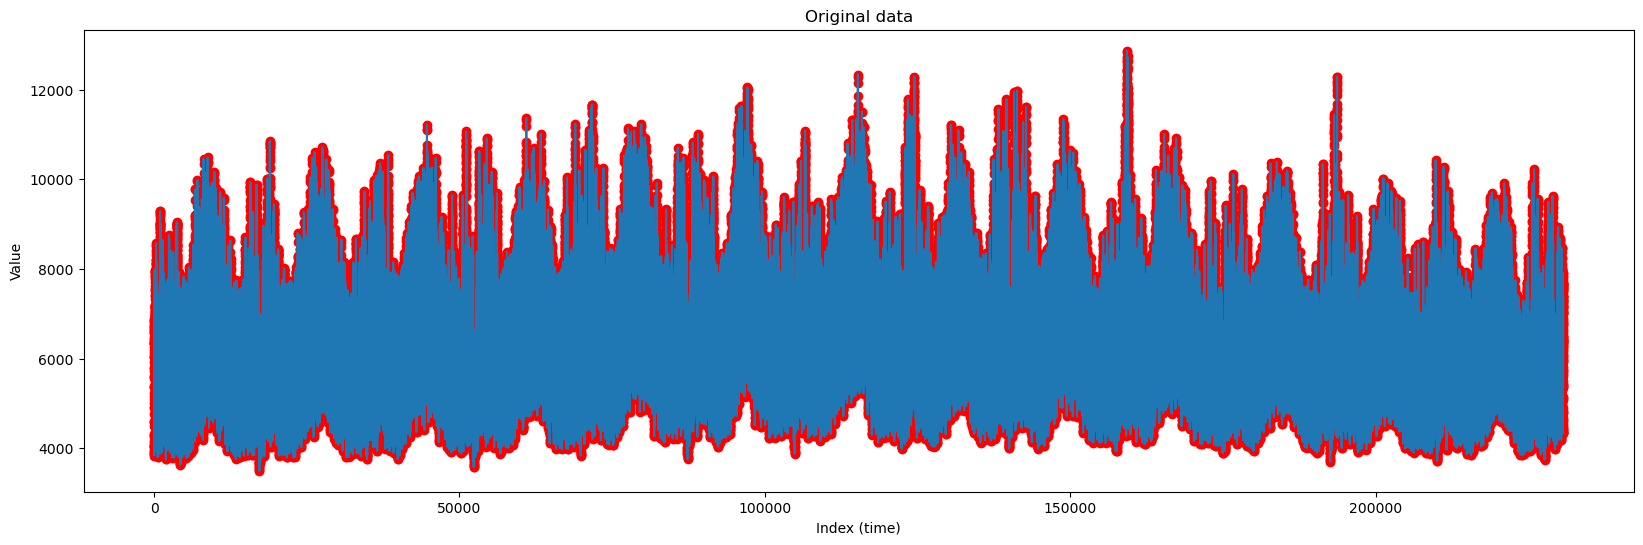

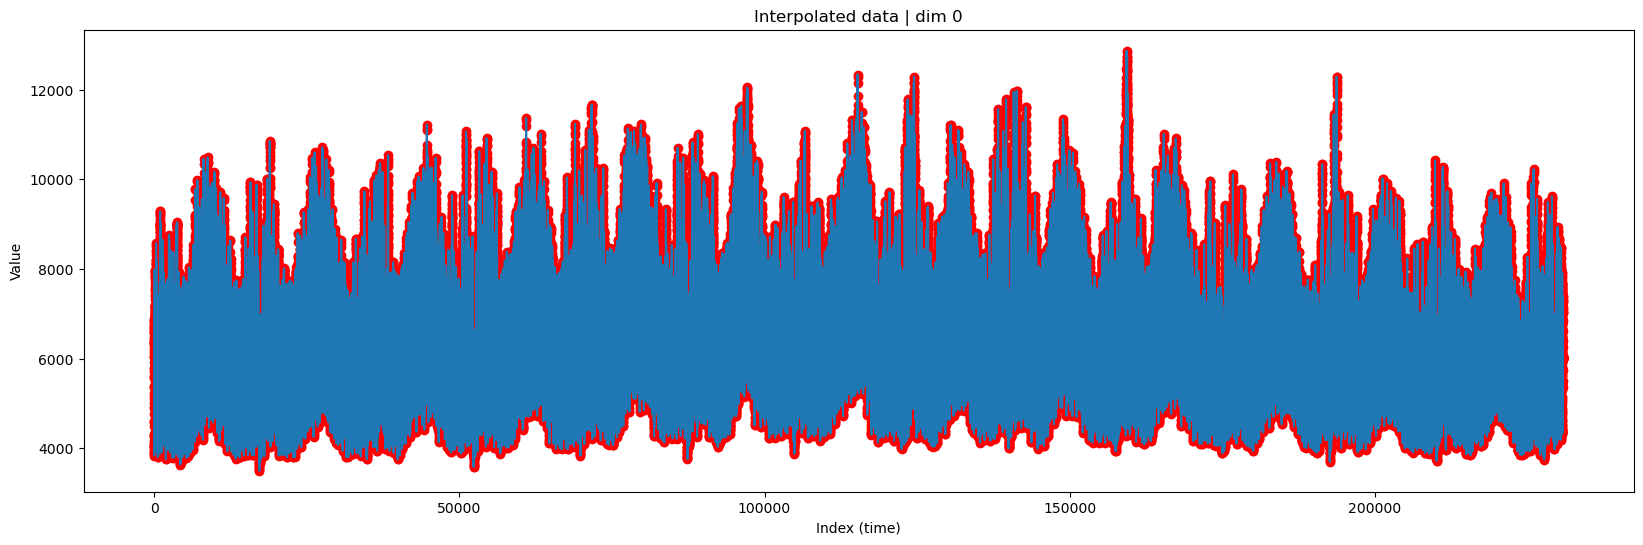

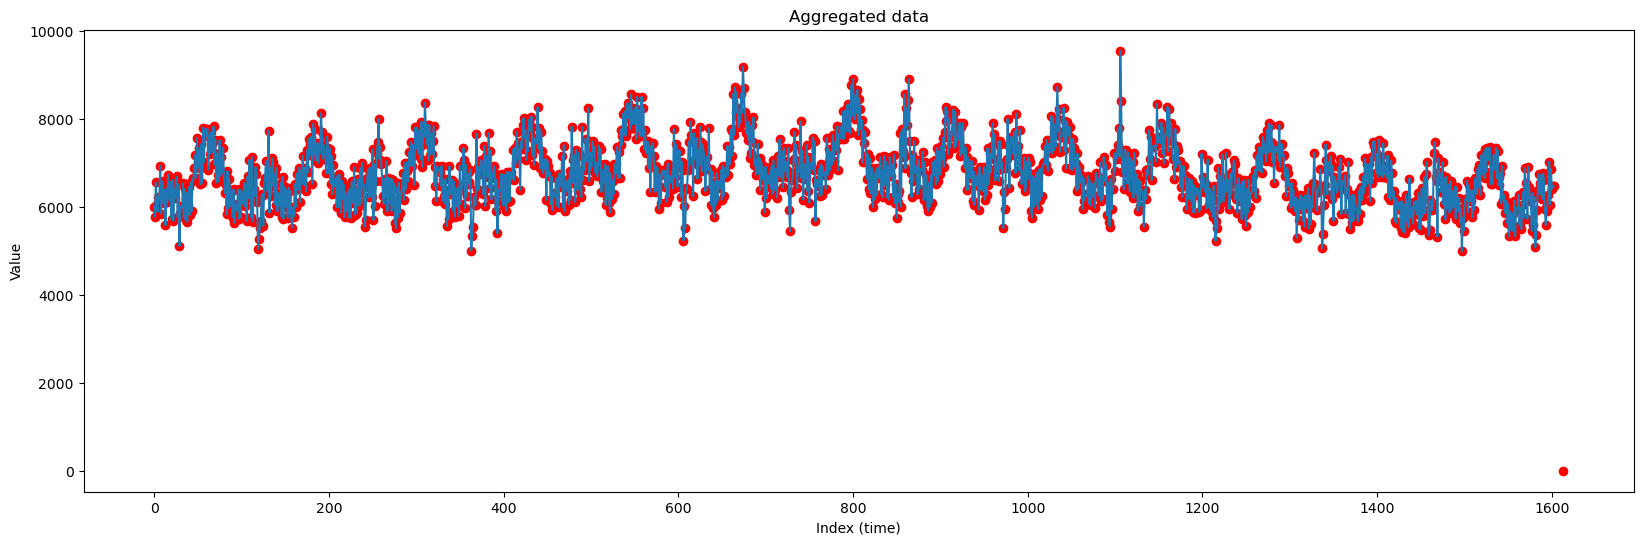

In [53]:
mplots.plot_with_dots(
    time_series             = ts[min: max],
    title                   = 'Original data',
    sequence_flag           = False
) 


paa_pipeline = mplots.Pipeline([
    ('interpolator', mplots.Interpolator(method='polynomial', n_segments = n_segments, plot_interpolated = True)),
    ('paa', mplots.PAATransformer(n_segments = n_segments))
])

ts_paa = paa_pipeline.fit_transform(ts)[0]

mplots.plot_with_dots(
    time_series             = ts_paa,
    title                   = 'Aggregated data',
    sequence_flag           = False
) 

In [65]:
ts_paa = np.array(ts_paa)

In [67]:
data_DistanceMatrix = mplots.DistanceMatrix(
    data = ts_paa,
    subsequence_len = w
)

In [68]:
data_MatrixProfile = mplots.MatrixProfile(
    data = ts_paa, 
    subsequence_len = w
)

In [69]:
data_MPlot = mplots.MatrixProfilePlot(
    DM_AB           = data_DistanceMatrix, 
    MP_AB           = data_MatrixProfile, 
    data            = ts_paa, 
    subsequence_len = w
)

In [71]:
data_MPlot.compute(
    mp_method          = 'scamp',
    dm_method          = 'scamp',
    print_flag         = False,
    debug              = False,
    time_flag          = True,
    allow_experimental = False, # Da pro
    ensure_symetric    = True
)

Check gpu use
True


In [ ]:
data_MPlot.plot(
    'Variable 0',
    'Scamp'
)

In [29]:
data_MPlot_cached = mplots.MatrixProfilePlotCached(
    data = ts
)

Selected dim 20 not multiple of subsequence length 12, setting up to subsequence_len
Final size: 24
[ Plot Matrix Interactive ] 24 | None
    Ratio: 1.0
dima 24, dimb 24
[ Get Matrix ]
 About to get data & data_b
    A: 0, 24: [5714.045004 5360.189078 5014.835118 4602.755516 4285.179828 4074.894442
 3942.936134 3883.997482 3877.679938 3837.716602 3897.023942 3964.149742
 4036.139836 4245.776094 4503.46147  4773.508194 5105.502952 5387.25472
 5593.59965  5787.18208  5929.757306 6063.754658 6183.790812 6261.027064]
    B: 0, 24: [5714.045004 5360.189078 5014.835118 4602.755516 4285.179828 4074.894442
 3942.936134 3883.997482 3877.679938 3837.716602 3897.023942 3964.149742
 4036.139836 4245.776094 4503.46147  4773.508194 5105.502952 5387.25472
 5593.59965  5787.18208  5929.757306 6063.754658 6183.790812 6261.027064]
Compute without GPU
matrix [(0, 24, 0, 24)] = [[ 1.          0.98509664  0.89761501  0.52600358 -0.09084061 -0.41806178
  -0.56723701 -0.66296723 -0.73918272 -0.81014997 -0.86

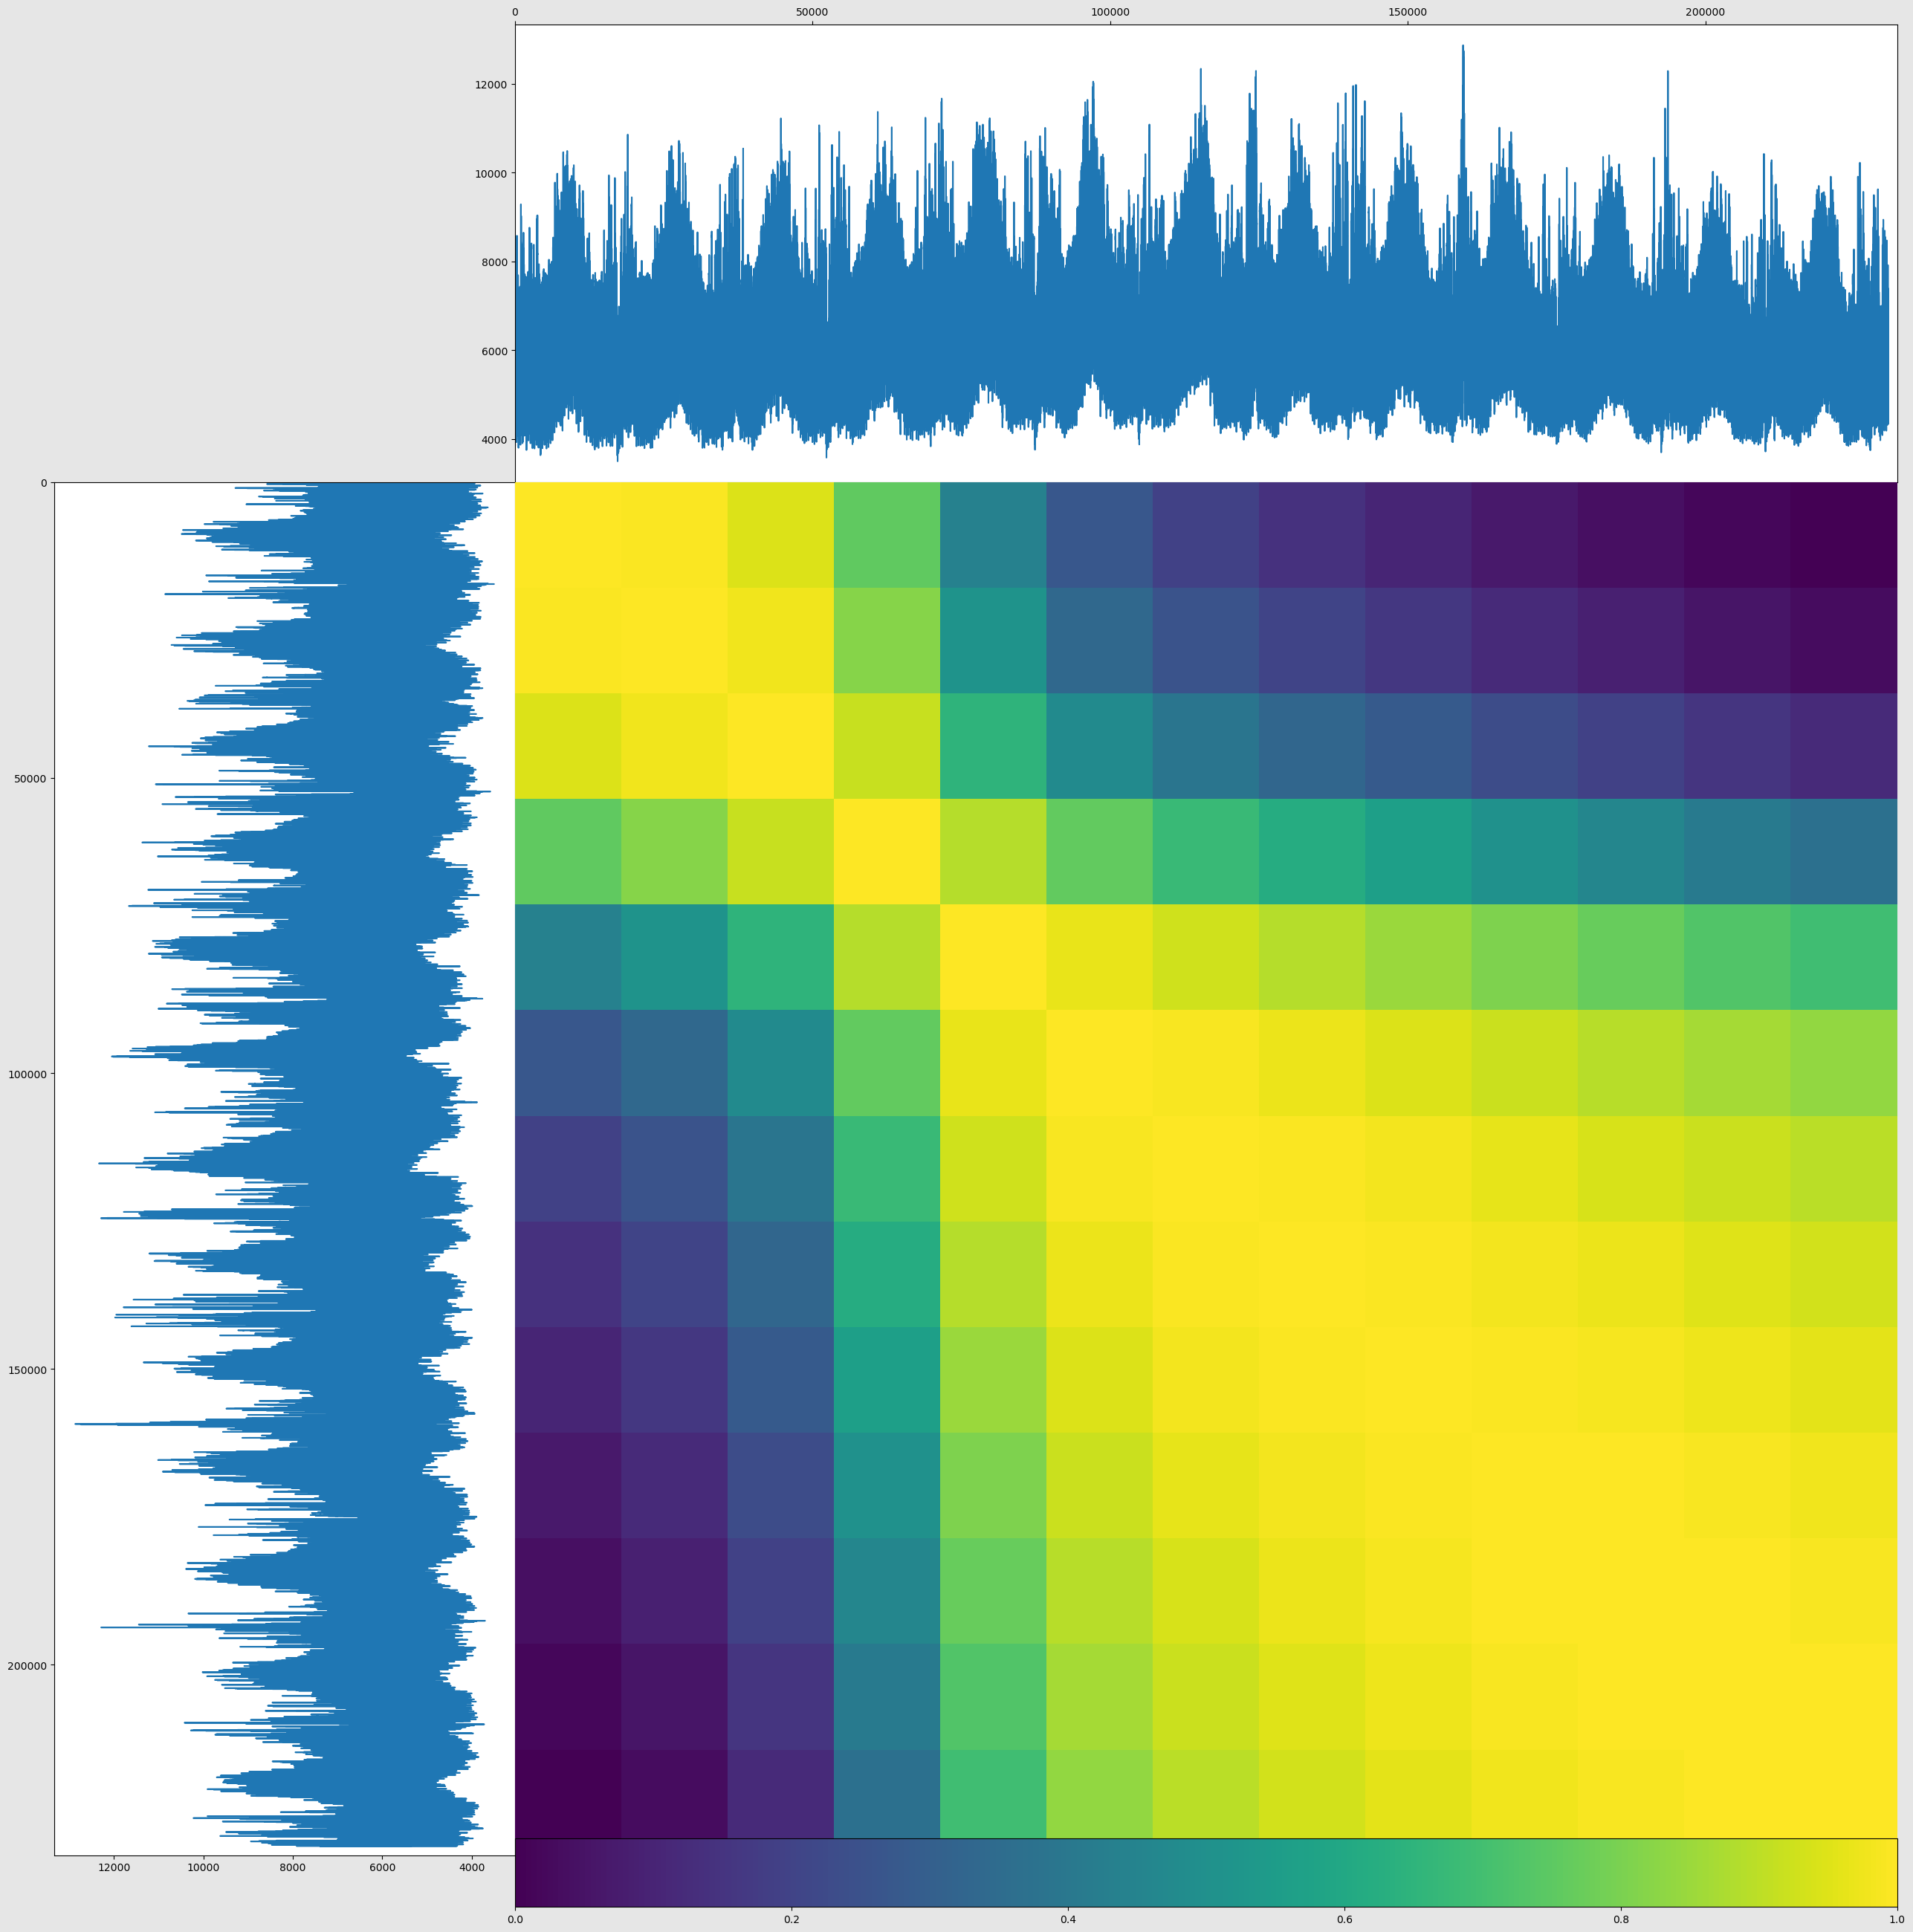

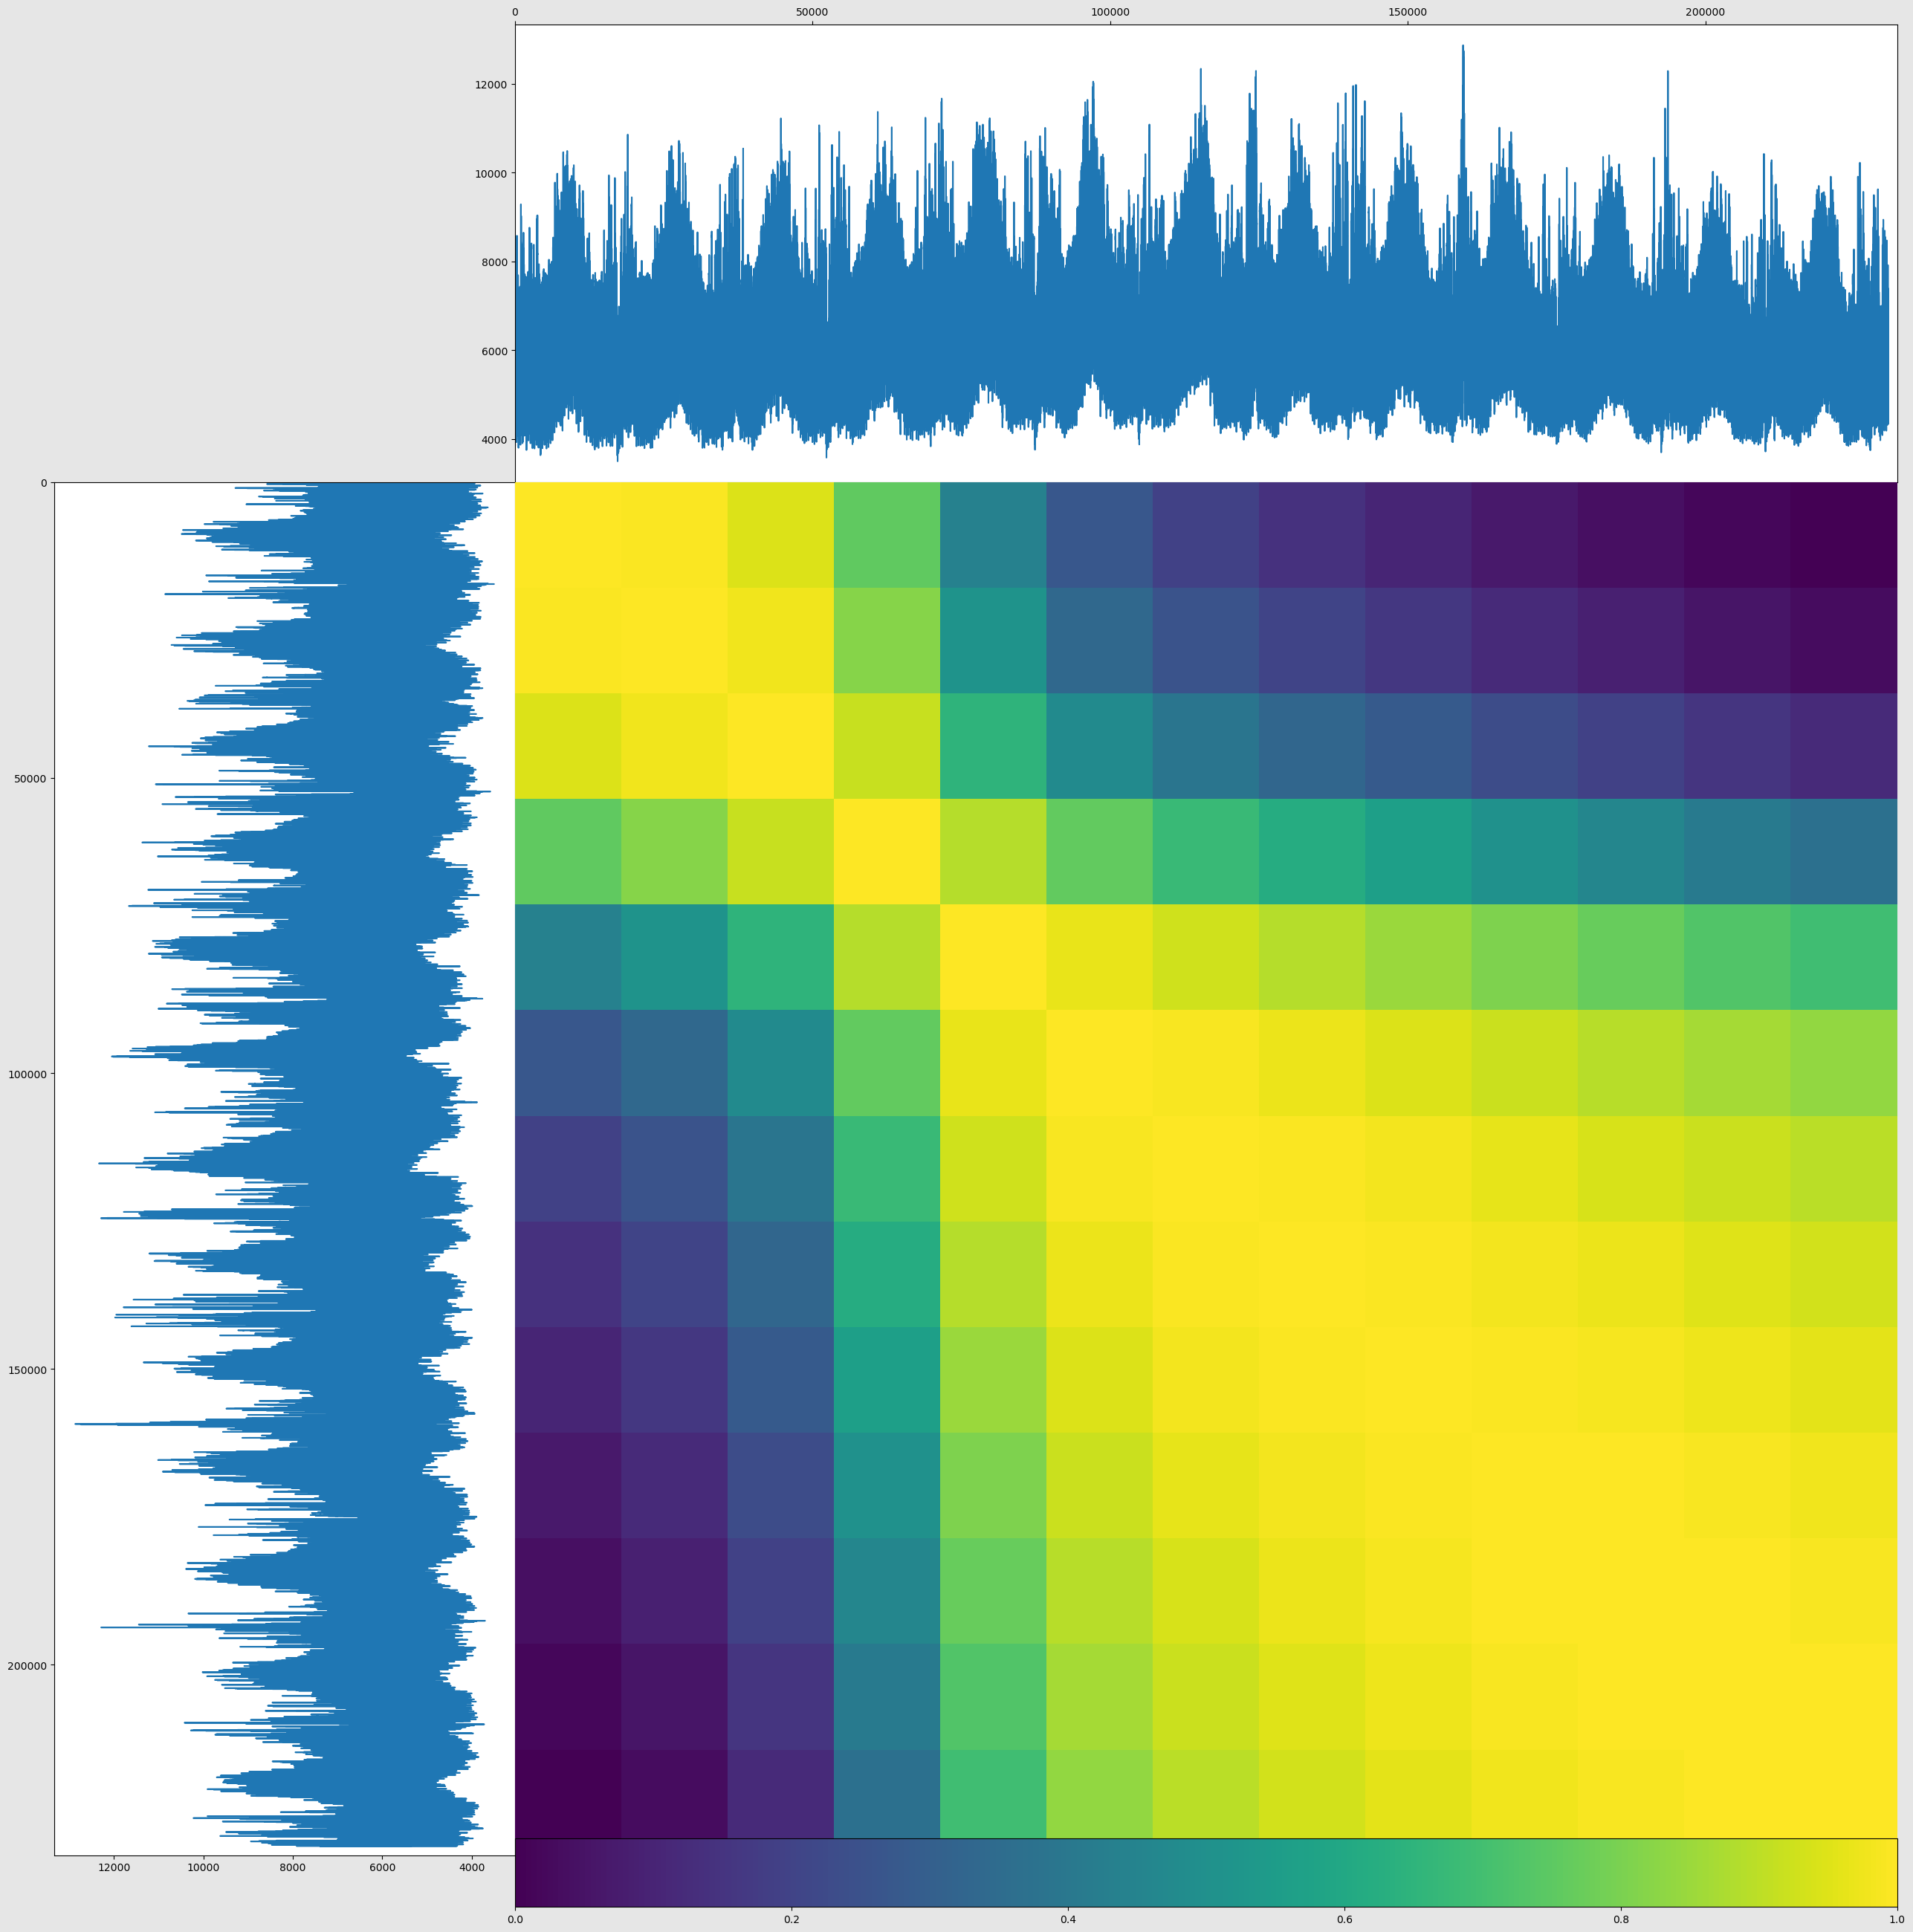

In [30]:
data_MPlot_cached.plot_matrix_interactive(
    matrix_dim = 20,
    print_flag = True,
    ensure_symetric = False
)    
    

#### Embeddings MPlot